# Predicting ICICIBANK stock price using LSTM

In this notebook, stock price prediction based on LSTM and timeseries data is demonstrated.

Based on the model predictions, data is also extrapolated considering the previously predicted values.

Referred articles :
https://medium.com/@matthew1992/forecasting-stock-with-different-models-arima-lstm-fourier-ef096885cf75
https://medium.com/@redeaddiscolll/stock-market-time-series-lstm-failure-56089ce3c0b8
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

## Importing the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
import math
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
!pip install pandas_ta
import pandas_ta as ta
import datetime
import seaborn as sns
from numpy.random import seed
seed(0)
from tqdm import tqdm
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=a30e569482aade2485af0d826e20b2fbd65427592725de15fb8bb31408b224ee
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Getting the ICICIBANK stock data

In [3]:
# Getting the stock data
ticker='ICICIBANK'
start='2000-01-01'
df = pdr.get_data_yahoo(str(ticker+".NS"), start=start)
# For training the data we will not be using Open, High, Low, Adj Close, Volume as this will not be present for extrapolation
# For extrapolation, we will do it in one step at a time where close price will be predicted based on previous features
# and then features for next step prediction will be generated based on predicted close price
df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df.head()
df

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2002-07-01,25.127272
2002-07-02,26.745455
2002-07-03,28.090908
2002-07-04,27.390909
2002-07-05,27.672728
...,...
2024-01-29,1016.400024
2024-01-30,1016.900024
2024-01-31,1028.150024


In [4]:
# Lets build the model on last two years data only
df=df[df.index>='2021-11-01']
df

,Close
Date,
2021-11-01,803.900024
2021-11-02,800.950012
2021-11-03,785.950012
2021-11-04,782.099976
2021-11-08,780.150024
...,...
2024-01-29,1016.400024
2024-01-30,1016.900024
2024-01-31,1028.150024


In [5]:
# lets check for nan values in the dataframe
df[df.isna().any(axis=1)]

,Close
Date,


In [6]:
#Lets delete the nan value if any
df=df.dropna()
df[df.isna().any(axis=1)]

,Close
Date,


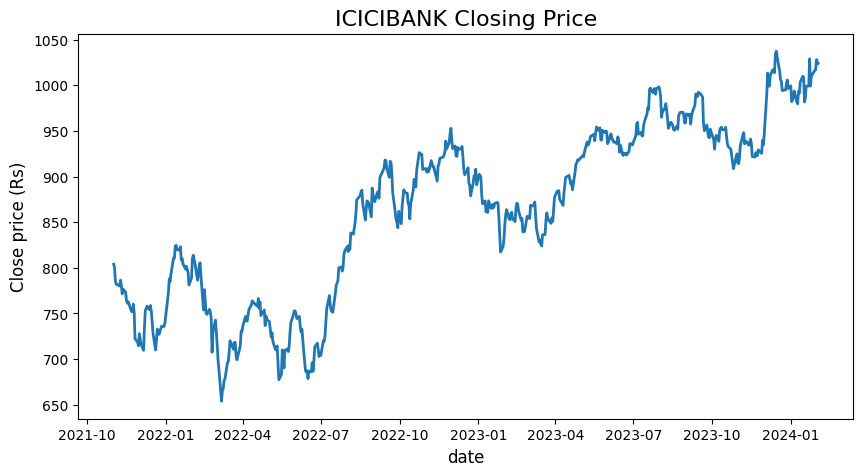

In [7]:
# Plotting close value data
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Close'], lw=2)
plt.xlabel("date")
plt.xlabel("date", fontsize=12)
plt.ylabel("Close price (Rs)", fontsize=12)
plt.title("ICICIBANK Closing Price", fontsize=16)
plt.show()

In [8]:
## Featurizing with technical indicators
def get_technical_indicators(dataset): #function to generate feature technical indicators


    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    dataset['ma50'] = dataset['Close'].rolling(window = 50).mean()

    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['50ema'] = dataset['Close'].ewm(span=50).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)


    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    dataset['momentum'] = (dataset['Close']/100)-1

    return dataset

In [9]:
ignore_first_points=51
df_TI=df.copy()
df_TI=get_technical_indicators(df_TI)
# Also as first 51 rows has Nan values lets ignore these rows
df_TI=df_TI.iloc[ignore_first_points:]
df_TI.head()

,Close,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,
2022-01-13,824.700012,805.171430,759.430952,755.705001,770.105706,761.708746,789.770059,19.664353,37.388740,835.122478,685.567518,822.676296,7.247
2022-01-14,820.000000,809.735718,763.185713,756.386001,773.865211,764.306389,794.421484,20.556273,38.846413,842.622824,687.237174,820.892099,7.200
2022-01-17,819.299988,814.628575,767.519046,757.130001,777.284334,766.744042,798.249409,20.965075,38.393570,847.184637,693.610358,819.830691,7.193
2022-01-18,823.099976,818.892857,772.907139,757.989000,780.728056,769.229381,802.072964,21.344907,38.218331,851.971660,699.098335,822.010214,7.231
2022-01-19,808.599976,818.585711,777.109520,758.430000,782.820761,770.957214,803.077206,20.256446,37.509231,854.343459,704.306535,813.070055,7.086


In [10]:
df_TI.tail()

,Close,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,
2024-01-29,1016.400024,1005.621443,996.790481,986.818004,998.330275,988.505193,1004.091099,5.760824,13.288051,1023.376109,970.223903,1013.776904,9.1640
2024-01-30,1016.900024,1009.985735,997.757150,988.436005,999.705812,989.618716,1006.061703,6.355891,14.024062,1025.723130,969.626882,1015.858984,9.1690
2024-01-31,1028.150024,1014.121451,999.126197,990.562006,1001.812791,991.129747,1009.459906,7.647116,15.082697,1030.135402,969.804613,1024.053011,9.2815
2024-02-01,1025.150024,1017.828596,1001.169056,992.636006,1003.541475,992.463876,1011.873770,8.332296,15.590809,1033.206626,970.843392,1024.784353,9.2515
2024-02-02,1024.000000,1017.107160,1003.071437,994.594006,1005.056921,993.700587,1013.739344,8.682423,15.914462,1035.696432,972.038584,1024.261451,9.2400


In [ ]:
df_TI[df_TI.isna().any(axis=1)]

,Close,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,


## Train and Test Data

In [11]:
# Define the parameters of number of features and look back period for time series generator
look_back = 30
n_features=12
# Lets validate the predictions on the last one months of data
test_prediction_start_date="2024-01-01"

In [12]:
# train / test split
train_data = df_TI.query('Date <  @test_prediction_start_date').reset_index(drop = False)
test_data_actual  = df_TI.query('Date >= @test_prediction_start_date').reset_index(drop = False)

# Lets add additinal samples = look_back from train_data at test top
test_add=train_data[-look_back:]
test_data = pd.concat([test_add,test_data_actual.loc[:]]).reset_index(drop=True)

In [13]:
test_data

,Date,Close,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2023-11-16,936.000000,938.764274,931.354760,948.248998,937.238134,943.186405,935.369737,-1.868396,11.903330,954.034155,906.420837,937.105961,8.3600
1,2023-11-17,921.849976,935.014274,929.828567,947.338998,936.098270,942.349682,933.289774,-2.808496,11.597277,952.327050,905.937940,926.935304,8.2185
2,2023-11-20,921.450012,932.971418,928.766663,946.399998,935.013214,941.530087,931.468272,-3.544942,11.608628,951.634752,905.200239,923.278443,8.2145
3,2023-11-21,926.099976,931.364275,928.307138,945.771997,934.352974,940.924985,930.642380,-3.710594,11.573186,951.231366,904.938623,925.159465,8.2610
4,2023-11-22,922.750000,929.099993,927.830947,944.913997,933.493494,940.212240,929.428168,-4.065326,11.623990,950.972974,904.477014,923.553155,8.2275
5,2023-11-23,923.000000,927.464277,927.499994,943.962997,932.716199,939.537250,928.439219,-4.276979,11.360202,950.790400,905.349590,923.184385,8.2300
6,2023-11-24,929.400024,925.792855,928.133330,942.985997,932.470556,939.139712,928.587035,-3.883521,10.400241,949.907978,908.307013,927.328145,8.2940
7,2023-11-28,925.500000,924.292855,928.935710,941.685997,931.954219,938.604822,928.112107,-3.842112,9.712861,949.170717,910.319274,926.109382,8.2550
8,2023-11-29,939.599976,926.828570,930.214280,940.681997,932.520571,938.643847,929.879471,-2.641100,9.881658,950.243308,910.716677,935.103111,8.3960
9,2023-11-30,934.950012,928.757141,930.692851,939.626997,932.700530,938.498991,930.659554,-2.040975,9.254165,949.968324,912.951665,935.001045,8.3495


In [14]:
train_data

,Date,Close,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2022-01-13,824.700012,805.171430,759.430952,755.705001,770.105706,761.708746,789.770059,19.664353,37.388740,835.122478,685.567518,822.676296,7.2470
1,2022-01-14,820.000000,809.735718,763.185713,756.386001,773.865211,764.306389,794.421484,20.556273,38.846413,842.622824,687.237174,820.892099,7.2000
2,2022-01-17,819.299988,814.628575,767.519046,757.130001,777.284334,766.744042,798.249409,20.965075,38.393570,847.184637,693.610358,819.830691,7.1930
3,2022-01-18,823.099976,818.892857,772.907139,757.989000,780.728056,769.229381,802.072964,21.344907,38.218331,851.971660,699.098335,822.010214,7.2310
4,2022-01-19,808.599976,818.585711,777.109520,758.430000,782.820761,770.957214,803.077206,20.256446,37.509231,854.343459,704.306535,813.070055,7.0860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,2023-12-22,994.299988,1016.185730,989.376197,956.751001,987.389042,971.884745,1004.844420,17.455378,36.007019,1064.709046,920.680969,998.368309,8.9430
481,2023-12-26,995.099976,1010.678580,992.809530,957.591001,987.960222,972.795146,1003.345274,15.385052,32.781018,1061.542041,930.417968,996.189420,8.9510
482,2023-12-27,1002.250000,1005.657148,996.278576,958.551001,989.018724,973.950238,1003.176771,14.158046,28.279304,1056.376113,943.258897,1000.229807,9.0225
483,2023-12-28,1005.900024,1003.435721,1000.107149,959.643002,990.269191,975.203171,1003.595733,13.326542,24.479554,1052.091616,954.173399,1004.009952,9.0590


In [33]:
X_train = train_data.drop(['Date','Close'],axis=1)
y_train = train_data['Close']

X_test = test_data.drop(['Date','Close'],axis=1)
y_test = test_data['Close']

# Lets reshape the outputs to match with time series generator requirement
y_train=y_train.values.reshape((len(y_train),1))
y_test=y_test.values.reshape((len(y_test),1))

In [34]:
X_train[X_train.isna().any(axis=1)]

,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum


In [35]:
X_test[X_test.isna().any(axis=1)]

,ma7,ma21,ma50,26ema,50ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum


In [36]:
# Min max scaling of X train and test data
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
print('Shape of X_train is ',X_train.shape)
print('Shape of y_train is ',y_train.shape)
print('Shape of X_test is ',X_test.shape)
print('Shape of y_test is ',y_test.shape)

Shape of X_train is  (485, 12)
Shape of y_train is  (485, 1)
Shape of X_test is  (54, 12)
Shape of y_test is  (54, 1)


## Time Series Generator
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [37]:
# Time series generator
train_generator = TimeseriesGenerator(X_train, y_train,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)
test_generator = TimeseriesGenerator(X_test, y_test,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

In [38]:
# Check for a sample time series generator
x, y = test_generator[0]
print('Shape of variable array is ',x.shape)
print('Shape of output array is ',y.shape)
print('%s => %s' % (x, y))

Shape of variable array is  (1, 30, 12)
Shape of output array is  (1, 1)
[[[0.75993409 0.76395833 0.90258744 0.81001766 0.87366038 0.76880053
   0.44966383 0.16580997 0.65626644 0.8094277  0.7368901  0.73569655]
  [0.7491305  0.75891759 0.89905786 0.80596992 0.87044296 0.76211408
   0.43466025 0.15804631 0.65113974 0.80795641 0.70927204 0.69881392]
  [0.74324513 0.75541031 0.89541579 0.80211681 0.8672914  0.75625851
   0.4229069  0.15833425 0.64906067 0.80570877 0.69934196 0.69777139]
  [0.73861503 0.75389258 0.89297999 0.79977225 0.86496462 0.75360352
   0.42026317 0.15743517 0.64784924 0.80491168 0.70444981 0.70989172]
  [0.73209173 0.75231981 0.8896521  0.79672018 0.86222392 0.7497002
   0.41460179 0.15872394 0.64707325 0.80350524 0.70008793 0.70115987]
  [0.72737931 0.75122673 0.8859635  0.79395995 0.8596284  0.74652103
   0.4112239  0.1520324  0.64652495 0.80616382 0.69908655 0.7018115 ]
  [0.72256402 0.75331853 0.88217405 0.79308765 0.85809976 0.74699621
   0.41750333 0.12768095 

In [39]:
# Confirmation on processing
y_test[look_back]

array([999.40002441])

In [40]:
train_generator[0][0].shape

(1, 30, 12)

## Model building

In [27]:
# Plotting while model train in tensorflow : https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5#:~:text=To%20plot%20the%20training%20progress,a%20list%20as%20its%20value.

from tensorflow import keras
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            # if logs['val_' + metric]:
            #     axs[i].plot(range(1, epoch + 2),
            #                 self.metrics['val_' + metric],
            #                 label='val_' + metric)

            axs[i].legend()
            if i == 0 :
              axs[0].set_ylim(0,10000)
            if i == 1 :
              axs[1].set_ylim(0,100)
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [28]:
# Lets build a model for prediction
callback_list=[PlotLearning()]
from keras.initializers import HeNormal
initializer = HeNormal()

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 20, kernel_initializer=initializer, activation='relu'))
model.add(Dense(units = 1, kernel_initializer=initializer, activation='relu'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            12600     
                                                                 
 dropout_4 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 30, 50)            0         
                                                                 
 flatten_2 (Flatten)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 20)                30020     
                                                                 
 dense_5 (Dense)             (None, 1)                

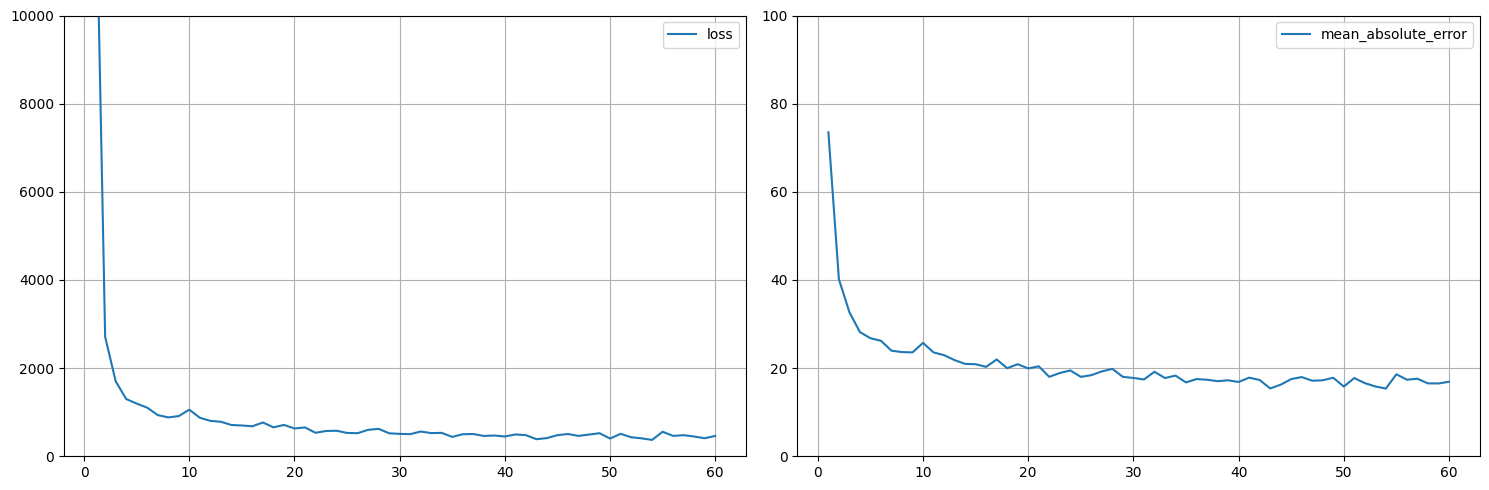

455/455 [==============================] - 11s 25ms/step - loss: 462.2532 - mean_absolute_error: 16.9056


In [41]:
model.fit(train_generator, epochs = 60, batch_size = 32, callbacks=callback_list,verbose=1)

In [42]:
# Lets dump the model
pickle_path = '/content/drive/MyDrive/Stock Predictions/DataFiles/'

pickle_out=open(pickle_path+'LSTM_ICICIBANK_Model.pickle', 'wb')
pickle.dump(model,pickle_out)
pickle_out.close()

In [ ]:
del model

In [ ]:
# Lets use the model for predictions
pickle_path = '/content/drive/MyDrive/Stock Predictions/DataFiles/'

pickle_in=open(pickle_path+"LSTM_ICICIBANK_Model.pickle","rb")
model=pickle.load(pickle_in)
pickle_in.close()

In [43]:
train_predictions  = model.predict(train_generator)
test_predictions  = model.predict(test_generator)

24/24 [==============================] - 0s 5ms/step


## Extrapolating

In [44]:
train_samples=400
y_test_extpr=[]
for i in tqdm(range(len(X_test)-look_back), desc = 'tqdm() Progress Bar'):
  lst=train_data['Close'][-train_samples:].tolist()
  # append the predicted value from second step
  if i>0:
    lst.extend(y_test_extpr)
  # Creating a dataframe from dictionary of lists
  dict = {'Close': lst}
  df_extpr = pd.DataFrame(dict)
  df_extpr=get_technical_indicators(df_extpr)
  # Last observations with lookback period
  df_extpr=df_extpr.iloc[train_samples-look_back+i:]
  df_extpr.reset_index(inplace=True)
  df_extpr.drop(columns=['index'],inplace=True)
  X_test_extpr = df_extpr.drop(['Close'],axis=1)
  X_test_extpr=scaler.transform(X_test_extpr)
  X_test_extpr=X_test_extpr.reshape((1,look_back, n_features))
  predicted_value = model.predict(X_test_extpr)[0]
  y_test_extpr.append(predicted_value[0])

tqdm() Progress Bar:   0%|          | 0/24 [00:00<?, ?it/s]

1/1 [==============================] - 1s 766ms/step


tqdm() Progress Bar:   4%|▍         | 1/24 [00:00<00:19,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  12%|█▎        | 3/24 [00:01<00:06,  3.50it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  21%|██        | 5/24 [00:01<00:03,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


tqdm() Progress Bar:  29%|██▉       | 7/24 [00:01<00:02,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  38%|███▊      | 9/24 [00:01<00:01,  8.12it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  46%|████▌     | 11/24 [00:01<00:01,  9.09it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  54%|█████▍    | 13/24 [00:01<00:01,  9.68it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  62%|██████▎   | 15/24 [00:02<00:00,  9.99it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  71%|███████   | 17/24 [00:02<00:00, 10.12it/s]

1/1 [==============================] - 0s 27ms/step


tqdm() Progress Bar:  79%|███████▉  | 19/24 [00:02<00:00, 10.46it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  88%|████████▊ | 21/24 [00:02<00:00, 10.68it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  96%|█████████▌| 23/24 [00:02<00:00, 10.85it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar: 100%|██████████| 24/24 [00:02<00:00,  8.25it/s]


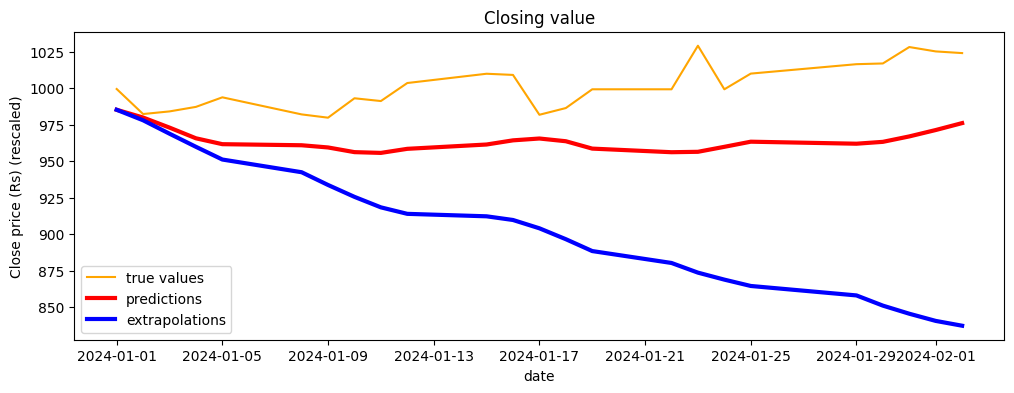

In [48]:
plt.figure(figsize=(12,4))
plt.plot(test_data.Date[look_back:], test_data['Close'][look_back:], c='orange',label='true values')
plt.plot(test_data.Date[look_back:],test_predictions.reshape(-1).tolist(), lw=3, c='r',linestyle = '-', label='predictions')
plt.plot(test_data.Date[look_back:],y_test_extpr, lw=3, c='b',linestyle = '-', label='extrapolations')
# plt.legend(loc="lower left")
plt.legend()
plt.xlabel("date", fontsize=10)
plt.ylabel("Close price (Rs) (rescaled)", fontsize=10)
plt.title("Closing value", fontsize=12);